In [2]:

import control
import numpy as np 
import matplotlib.pyplot as plt
import math


## Tentativa de simular circuito trifásico inversor

In [170]:
# definindo matrizes de Espaço de Estados para cada subtopologia

Ra = 1
Rb = 1
Rc = 1

La = 1e-3
Lb = 1e-3
Lc = 1e-3

Kwa = 1
Kwb = 1
Kwc = 1


A_ab= [-(Ra + Rb)/(La+Lb)]
A_ac= [-(Ra + Rc)/(La+Lc)]
A_bc= [-(Rb + Rc)/(Lb+Lc)]

B_ab = 1/(La+Lb)
B_ac = 1/(La+Lc)
B_bc = 1/(Lb+Lc)

C_ab = [1]
C_ac = [1]
C_bc = [1]

G_ab = [-(Kwa + Kwb)/(La+Lb)]
G_ac = [-(Kwa + Kwc)/(La+Lc)]
G_bc = [-(Kwb + Kwc)/(Lb+Lc)]

D_ab = [0, 0]
D_ac = [0, 0]
D_bc = [0, 0]

#unifica B e G numa matriz de entradas B_ext para ser compatível com biblioteca control
#Considerando o vetor u de entradas como [v(t)]
#                                        [w(t)]
B_ext_ab = np.hstack((B_ab, G_ab))
B_ext_ac = np.hstack((B_ac, G_ac))
B_ext_bc = np.hstack((B_bc, G_bc))

#Vamos simplificar e considerar w(t) uma constante, para manter um tempo de comutação constante

w = 2*np.pi #2pi radianos/seg

# Parâmetros de simulação
dt = 1e-3
t_total = 3
N = int(t_total / dt)

#condições iniciais
x0 = [0]


# Modelos
subtops = [
    control.ss(A_ab, B_ext_ab, C_ab, D_ab),
    control.ss(A_ac, B_ext_ac, C_ac, D_ac),
    control.ss(A_bc, B_ext_bc, C_ac, D_ac),
]

i_vec = np.zeros(N)
idx_vec = np.zeros(N)
t_vec = np.linspace(0, t_total, N)


print(len(t_vec))
print(t_vec)
print(len(i_vec))


3000
[0.00000000e+00 1.00033344e-03 2.00066689e-03 ... 2.99799933e+00
 2.99899967e+00 3.00000000e+00]
3000


## Simulação considerando velocidade angular como perturbação que cresce linearmente

In [1]:
# Simulação
for i in range(N):
    t = t_vec[i]
    #define dinamica das entradas
    #degrau para V e rampa saturada para w
    if t < 1e-3:
        V = 0
        w = 0
    else:
        V = 36
        if(w < 2*np.pi):
            w = w + 0.1
            T = (2*np.pi/w)/6 #tempo que dura uma subtopologia
    print(T)

    u = [V, w]  # entrada: [V, omega]
    U_local = np.array([[V, V],
                        [w, w]])
    idx = int((t // T) % 3)  # subtopologia ativa
    idx_vec[i] = idx
    sys = subtops[idx]

    T_local = [0, dt]

    _, yout, xout = control.forced_response(sys, T_local, U_local, X0=x0, return_x = True)

    i_vec[i] = yout[0, 1]
    x0 = xout[:, -1]


# Plot com cores diferentes em cada subtopologia
colors = ['blue', 'green', 'red']
labels = ['Subtopologia AB', 'Subtopologia AC', 'Subtopologia BC']
already_plotted = [False, False, False]

for i in range(1, len(t_vec)):
    idx = int(idx_vec[i])  # subtopologia atual
    color = colors[idx]
    label = labels[idx] if not already_plotted[idx] else None

    plt.plot(t_vec[i-1:i+1], i_vec[i-1:i+1], color=color, label=label)
    already_plotted[idx] = True

plt.xlabel('Tempo (s)')
plt.ylabel('Corrente da fonte (A)')
plt.title('Corrente com Comutação BLDC')
plt.grid()
plt.legend(loc='upper right')
plt.show()

NameError: name 'N' is not defined

In [181]:
#Simulando correntes e tensões de fase

A_ab = [-(Ra+Rb)/(La+Lb), 0, (Ra+Rb)/(La+Lb)]
A_ac = [-(Ra+Rc)/(La+Lc), 0, (Ra+Rc)/(La+Lc)]
A_bc = [-(Rb+Rc)/(Lb+Lc), 0, (Rb+Rc)/(Lb+Lc)]


B_ab = [1/(La+Lb), 0, 0]
B_ac = [0, 1/(La+Lc), 0]
B_bc = [0, 0, 1/(Lb+Lc)]

C_ab = [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]

C_ac = [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]

C_bc = [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]

G_ab = [[-Kwa/(La+Lb)],
       [-Kwb/(La+Lb)],
       [0]]

G_ac = [[-Kwa/(La+Lc)],
       [0],
       [-Kwc/(La+Lc)]]
G_bc = [[0],
       [-Kwb/(Lb+Lc)],
       [-Kwc/(Lb+Lc)]]



D_ab = [[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]]

D_ac = [[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]]

D_bc = [[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]]

B_ext_ab = np.hstack((B_ab, G_ab))
# Modelos
subtops = [
    control.ss(A_ab, B_ext_ab, C_ab, D_ab),
    control.ss(A_ac, B_ext_ac, C_ac, D_ac),
    control.ss(A_bc, B_ext_bc, C_ac, D_ac),
]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

## Simulação de modelo DC do inversor (Matheus)


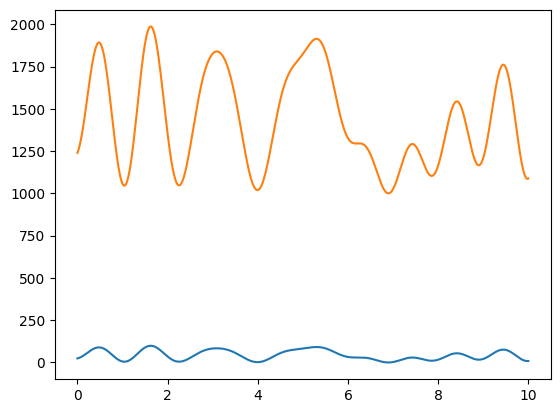

In [15]:

## Primeiro, construir sinais de entrada (multiseno ou Standard PWM)

N = 10 # ordem multiseno

w_max = 2*np.pi
w_min = 0.1*np.pi

# Vetor de tempo com resolução adequada
t = np.linspace(0, 10, 1000)  # 10 segundos, 1000 amostras
u = np.zeros_like(t)

# Construção do sinal multiseno
for j in range(1, N+1):
    w_j = w_min + (j-1)*(w_max - w_min)/(N-1)  # Frequência harmônica
    fase_j = j*(j+1)*np.pi / N                 # Fase única para cada seno
    u += np.cos(w_j * t + fase_j)


# Normalizar o sinal para o intervalo [-1, 1]
u = u / np.max(np.abs(u))

# Mapear para intervalo [1000, 2000] microsegundos
PWM_min = 1000  # microsegundos
PWM_max = 2000

# Equação de mapeamento: u_normalizado ∈ [-1, 1] → u_mapeado ∈ [1000, 2000]
gain = (PWM_max - PWM_min) / 2        # 500
offset = (PWM_max + PWM_min) / 2      # 1500

u_pwm = gain * u + offset
u_percentual = (u_pwm - PWM_min) / (PWM_max - PWM_min) * 100

plt.plot(t, u_percentual)
# plt.plot(t, u_pwm)

        


In [23]:
#ordem do modelo
N = 2

theta = np.zeros((4*N - 1, 1))

phi = np.zeros()


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])